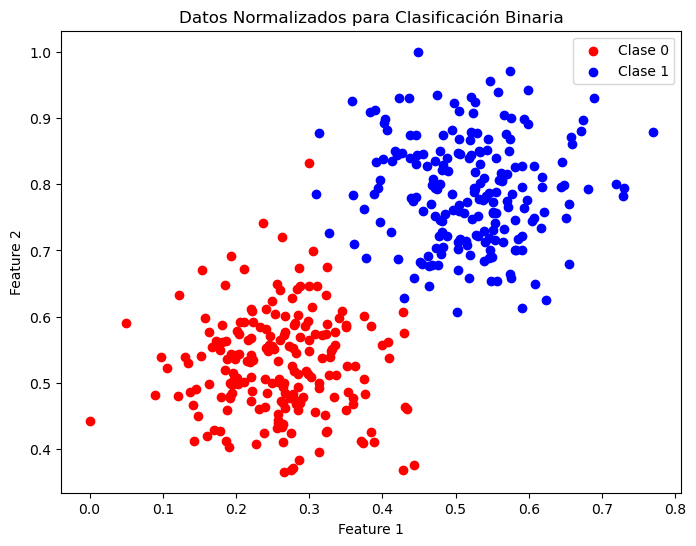

In [40]:
import matplotlib.pyplot as plt
import numpy as np
# Generar datos aleatorios para dos clases
np.random.seed(42)
num_samples_per_class = 200

# Clase 0 con media [1, 2] y desviación estándar [0.1, 0.5]
class_0 = np.random.normal(loc=[1, 2], scale=[0.3, 0.3], size=(num_samples_per_class, 2))

# Clase 1 con media [2, 3] y desviación estándar [0.2, 0.3]
class_1 = np.random.normal(loc=[2, 3], scale=[0.3, 0.3], size=(num_samples_per_class, 2))

# Crear el array con los datos
data = np.vstack([class_0, class_1])
labels = np.array([0] * num_samples_per_class + [1] * num_samples_per_class)

# Normalizar los datos en el rango [0, 1]
data= (data - data.min()) / (data.max() - data.min())

data_combined = np.hstack((data, labels[:, None]))


# Graficar los datos
plt.figure(figsize=(8, 6))
plt.scatter(data[labels == 0][:, 0], data[labels == 0][:, 1], c='red', label='Clase 0')
plt.scatter(data[labels == 1][:, 0], data[labels == 1][:, 1], c='blue', label='Clase 1')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.title('Datos Normalizados para Clasificación Binaria')
plt.show()


In [41]:
data_combined=data_combined[0:20,0:2]
data_combined

array([[0.29807714, 0.51325153],
       [0.31011626, 0.64572779],
       [0.23979571, 0.50560637],
       [0.38439862, 0.58547451],
       [0.22103055, 0.56754237],
       [0.22151353, 0.48713851],
       [0.27776251, 0.37170677],
       [0.12091797, 0.47943872],
       [0.17770176, 0.54933607],
       [0.18605937, 0.41165605],
       [0.3753427 , 0.50627307],
       [0.26385264, 0.41066369],
       [0.21505715, 0.53312239],
       [0.1666843 , 0.55423632],
       [0.21057114, 0.50101663],
       [0.21048598, 0.67198297],
       [0.25739145, 0.43993227],
       [0.32405979, 0.42692361],
       [0.27512312, 0.36800751],
       [0.15255447, 0.53997538]])

In [42]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import numpy as np
import os
import tensorflow as tf
import strawberryfields as sf
from strawberryfields import ops
import sys
from itertools import combinations
import warnings
warnings.filterwarnings("ignore")
physical_devices = tf.config.experimental.list_physical_devices('CPU')
tf.config.experimental.set_visible_devices(physical_devices[0])






data_points=len(data_combined)

def init_weights(modes, layers, active_sd=0.1, passive_sd=1):
    # Number of interferometer parameters:
    M = int(modes * (modes - 1)) 

    # Create the TensorFlow variables
    int1_weights = tf.random.normal(shape=[layers, M], stddev=passive_sd)
    r1_weights = tf.random.normal(shape=[layers, modes], stddev=passive_sd)
    int2_weights = tf.random.normal(shape=[layers, M], stddev=passive_sd)
    s_mag_weights = tf.random.normal(shape=[layers, modes], stddev=active_sd)
    s_phase_weights = tf.random.normal(shape=[layers, modes], stddev=passive_sd)
    r2_weights = tf.random.normal(shape=[layers, modes], stddev=passive_sd)
    dr_weights = tf.random.normal(shape=[layers, modes], stddev=active_sd)
    dp_weights = tf.random.normal(shape=[layers, modes], stddev=passive_sd)
    k_weights = tf.random.normal(shape=[layers, modes], stddev=active_sd)

    weights = tf.concat([int1_weights, r1_weights, s_mag_weights,s_phase_weights, int2_weights, r2_weights, dr_weights, dp_weights, k_weights], axis=1)

    weights = tf.Variable(weights)

    return weights

def input_qnn_layer(hid,q):
    with tf.name_scope('inputlayer'):
        ops.Dgate(hid[0]) | q[0]
        ops.Dgate(hid[1]) | q[1]

# Defining standard QNN layers
def qnn_layer(params,layer_number,q):
    with tf.name_scope('layer_{}'.format(layer_number)):
        N = len(q)
        M = int(modes * (modes - 1)) 
        
        int1 = params[:M]
        r1=params[M:M+N]
        sm = params[M+N:M+2*N]
        sp = params[M+2*N:M+3*N]
        int2 = params[M+3*N:2*M+3*N]
        r2=params[2*M+3*N:2*M+4*N]
        dr = params[2*M+4*N:2*M+5*N]
        dp = params[2*M+5*N:2*M+6*N]
        ker = params[2*M+6*N:2*M+7*N]
        
        theta1=int1[:len(int1)//2]
        phi1=int1[len(int1)//2:]
        
        theta2=int2[:len(int2)//2]
        phi2=int2[len(int2)//2:]
        
        
        
        for k, (q1, q2) in enumerate(combinations(q,2)):
            ops.BSgate(theta1[k], phi1[k]) | (q1, q2)

        for i in range(N):
            ops.Rgate(r1[i]) | q[i]

        for i in range(N):
            ops.Sgate(sm[i],sp[i]) | q[i]

        for k, (q1, q2) in enumerate(combinations(q,2)):
            ops.BSgate(theta2[k], phi2[k]) | (q1, q2)

        for i in range(N):
            ops.Rgate(r2[i]) | q[i]

        for i in range(N):
            ops.Dgate(dr[i], dp[i]) | q[i]

        for i in range(N):
            ops.Kgate(ker[i]) | q[i]


modes=2
cutoff_dim=6
batch_size=20
layers=10
hidden_units=2


eng = sf.Engine(backend="tf", backend_options={"cutoff_dim": cutoff_dim,"batch_size": batch_size})
qnn = sf.Program(modes)

# initialize QNN weights
weights = init_weights(modes, layers) # our TensorFlow weights
num_params = np.prod(weights.shape) 

sf_params = np.arange(num_params).reshape(weights.shape).astype(np.str)
sf_params = np.array([qnn.params(*i) for i in sf_params])

hid_params = np.arange(num_params,num_params+hidden_units).reshape(hidden_units,1).astype(np.str)
hid_params = np.array([qnn.params(*i) for i in hid_params])

with qnn.context as q:
    input_qnn_layer(hid_params,q)
    for k in range(layers):
        qnn_layer(sf_params[k],k, q)


def cost(weights, X):
     
    mapping_wt = {p.name: w for p, w in zip(sf_params.flatten(), tf.reshape(weights, [-1]))}
    mapping_hid={p.name: w for p, w in zip(hid_params, tf.transpose(X))} 
    mapping_wt.update(mapping_hid)
    results = eng.run(qnn, args=mapping_wt)
    ket = results.state.ket()
    func_to_minimise = 0


# Building up the function to minimize by looping through batch
    for i in range(batch_size):
        
        data_points_complex = tf.cast(X, dtype=tf.complex64)
        expanded_data_points = tf.expand_dims(data_points_complex, axis=1)  # Agregar dimensión 1 en el medio
        expanded_data_points = tf.tile(expanded_data_points, [1, 6, 3])  # Replicar en dimensión 10


        
        # Probabilities corresponding to a single photon in either mode
        prob = tf.abs(tf.reduce_sum(tf.math.conj(ket) * expanded_data_points)) ** 2
        # These probabilities should be optimised to 1
        func_to_minimise += (1.0 / batch_size) * (prob - 1) ** 2
    return func_to_minimise  



optimizer = tf.keras.optimizers.Adam()

loss_ls=[]
for i in range(200):
    split_data = np.split(data_combined, data_points / batch_size)

    for batch in split_data:
        data_points_principal_components = batch[:,0:2]

        with tf.GradientTape() as tape:
            loss=cost(weights, data_points_principal_components)
        gradients=tape.gradient(loss,weights)
        optimizer.apply_gradients(zip([gradients],[weights]))

        loss_ls.append(loss)
        
        if eng.run_progs:
            eng.reset()
    print("loss at iteration {} is {}".format(i,loss))


loss at iteration 0 is 176.55831909179688
loss at iteration 1 is 138.97557067871094
loss at iteration 2 is 107.41697692871094
loss at iteration 3 is 81.24405670166016
loss at iteration 4 is 59.87371826171875
loss at iteration 5 is 42.87470626831055
loss at iteration 6 is 29.845653533935547
loss at iteration 7 is 20.275903701782227
loss at iteration 8 is 13.536243438720703
loss at iteration 9 is 8.960840225219727
loss at iteration 10 is 5.941031455993652
loss at iteration 11 is 3.98382306098938
loss at iteration 12 is 2.725266933441162
loss at iteration 13 is 1.914820671081543
loss at iteration 14 is 1.3879649639129639
loss at iteration 15 is 1.0399258136749268
loss at iteration 16 is 0.8051038384437561
loss at iteration 17 is 0.6426505446434021
loss at iteration 18 is 0.5270385146141052
loss at iteration 19 is 0.4422144591808319
loss at iteration 20 is 0.37793752551078796
loss at iteration 21 is 0.3276224732398987
loss at iteration 22 is 0.2869684100151062
loss at iteration 23 is 0.253